# New York City Taxi & Limousine Commission (NYC TLC)
## Tree-Based Modeling for Tip Prediction for the Taxi Ride Fare Project

### **Project Description**

#### Overview:
Purpose: Predict customer tipping propensity.\
Objective: Build predictive model(s) for taxi ride fares to increase taxi driver profitability.

#### Problem: 
Initial consideration was to predict non-tippers, however, ethical concerns about fairness and potential bias against both drivers and passengers led to a different approach. This new model identifies riders who are likely to be generous tippers (defined as those leaving a tip of 20% or more).  This shift is thought to create a win-win situation for both drivers and passengers.

#### Solution:
Build a machine learning model to predict whether or not a NYC TLC taxi cab rider will be a generous tipper. 

**Acknowledging the importance of mitigating potential issues:**

* False Positives (Type 1 Errors): If the model incorrectly predicts a generous tip but the customer doesn't tip (or tips low), drivers might miss out on additional income.  Additionally, drivers might lose trust in the system.
  
* False Negatives (Type 2 Errors):  If the model incorrectly predicts a low tip, it may disincentivize drivers from picking up these passengers. This could lead to longer wait times for passengers and decreased accessibility for those who genuinely want to tip but the model misjudged.

The goal is to develop a model that minimizes these errors and aim for a fair and positive experience for both drivers and passengers.

### **Change Log**

2024_0604, S. Souto, Initial Version

### **Data Sources**

1. Original data: NYC.gov: "2017_Yellow_Taxi_Trip_Data.csv"
2. Supplemental data: mean durations, mean distances, and predicted fares from separate notebook effort: "nyc_preds_means.csv"

### **Imports and Data Loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.\
Ensure XGBoost is installed in environment before proceeding.

In [1]:
# Import packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Notebook Setup
pd.set_option('display.max_columns', None)

In [3]:
# Load dataset into dataframe
df0 = pd.read_csv('data/2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous EDA effort
nyc_preds_means = pd.read_csv('data/nyc_preds_means.csv')

In [4]:
# Inspect original data
df0.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.0,0.3,59.16
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.0,0.3,19.58
8,8433159,2,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,1,1.20,1,N,234,249,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55


In [5]:
# Inspect supplemental data
nyc_preds_means.head(10)

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642
5,11.855376,2.052258,10.441351
6,59.633333,12.830000,45.374542
7,26.437500,4.022500,18.555128
8,7.873457,1.019259,7.151511
9,10.541111,1.580000,9.122755


#### Join and create one dataframe for analysis

In [6]:
# Merge datasets
df0 = df0.merge(nyc_preds_means, left_index=True, right_index=True)

df0.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.0,0.3,59.16,59.633333,12.830000,45.374542
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.0,0.3,19.58,26.437500,4.022500,18.555128
8,8433159,2,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,1,1.20,1,N,234,249,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80,7.873457,1.019259,7.151511
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55,10.541111,1.580000,9.122755


### **Feature Engineering**

In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

Customers who pay cash generally have a tip amount of $0. 
Customers who pay with card tend to leave tips.
In order to gauge tip percentage, tipping customers are needed.  Filter the data to select only the customers who pay with credit card.
Column source: payment_type
* 1= Credit card 
* 2= Cash 

In [8]:
# Isolate only customers who paid with credit card
df1 = df0[df0.payment_type == 1].copy()

#### Create or Modify Features

##### Create Target Variable
1. Calculate `tip percent` column
2. Create binary `generous` column as target

* `tip_percent` column will use the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

* `generous` column: binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

In [9]:
# Create tip % col
# Round the float to three places for better precision in filtering
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)

Create target variable:
1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [10]:
#Create 'generous' col (target)
df1['generous'] = df1['tip_percent']
df1

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.00,0.3,16.56,22.847222,3.521667,16.434245,0.200,0.200
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.00,0.3,20.80,24.470370,3.108889,16.052218,0.238,0.238
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.250000,0.881429,7.053706,0.199,0.199
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,3.700000,18.731650,0.300,0.300
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.00,0.3,12.36,11.855376,2.052258,10.441351,0.200,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22692,60425673,1,07/16/2017 3:22:51 AM,07/16/2017 3:40:52 AM,1,5.70,1,N,249,17,1,19.0,0.5,0.5,4.05,0.00,0.3,24.35,18.016667,5.700000,19.426247,0.200,0.200
22693,67858616,2,08/10/2017 10:20:04 PM,08/10/2017 10:29:31 PM,1,0.89,1,N,229,170,1,7.5,0.5,0.5,1.76,0.00,0.3,10.56,8.095370,1.062778,7.300146,0.200,0.200
22695,66632549,2,08/06/2017 4:43:59 PM,08/06/2017 5:24:47 PM,1,16.71,2,N,132,164,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,59.560417,18.757500,52.000000,0.250,0.250
22697,60217333,2,07/15/2017 12:56:30 PM,07/15/2017 1:08:26 PM,1,2.36,1,N,68,144,1,10.5,0.0,0.5,1.70,0.00,0.3,13.00,16.650000,2.077500,11.707049,0.150,0.150


In [11]:
#Convert to boolean
df1['generous'] = (df1['generous'] >= 0.2)
df1

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.00,0.3,16.56,22.847222,3.521667,16.434245,0.200,True
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.00,0.3,20.80,24.470370,3.108889,16.052218,0.238,True
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.250000,0.881429,7.053706,0.199,False
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,3.700000,18.731650,0.300,True
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.00,0.3,12.36,11.855376,2.052258,10.441351,0.200,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22692,60425673,1,07/16/2017 3:22:51 AM,07/16/2017 3:40:52 AM,1,5.70,1,N,249,17,1,19.0,0.5,0.5,4.05,0.00,0.3,24.35,18.016667,5.700000,19.426247,0.200,True
22693,67858616,2,08/10/2017 10:20:04 PM,08/10/2017 10:29:31 PM,1,0.89,1,N,229,170,1,7.5,0.5,0.5,1.76,0.00,0.3,10.56,8.095370,1.062778,7.300146,0.200,True
22695,66632549,2,08/06/2017 4:43:59 PM,08/06/2017 5:24:47 PM,1,16.71,2,N,132,164,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,59.560417,18.757500,52.000000,0.250,True
22697,60217333,2,07/15/2017 12:56:30 PM,07/15/2017 1:08:26 PM,1,2.36,1,N,68,144,1,10.5,0.0,0.5,1.70,0.00,0.3,13.00,16.650000,2.077500,11.707049,0.150,False


In [12]:
#Convert to binary
df1['generous'] = df1['generous'].astype(int)
df1

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.00,0.3,16.56,22.847222,3.521667,16.434245,0.200,1
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.00,0.3,20.80,24.470370,3.108889,16.052218,0.238,1
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.250000,0.881429,7.053706,0.199,0
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,3.700000,18.731650,0.300,1
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.00,0.3,12.36,11.855376,2.052258,10.441351,0.200,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22692,60425673,1,07/16/2017 3:22:51 AM,07/16/2017 3:40:52 AM,1,5.70,1,N,249,17,1,19.0,0.5,0.5,4.05,0.00,0.3,24.35,18.016667,5.700000,19.426247,0.200,1
22693,67858616,2,08/10/2017 10:20:04 PM,08/10/2017 10:29:31 PM,1,0.89,1,N,229,170,1,7.5,0.5,0.5,1.76,0.00,0.3,10.56,8.095370,1.062778,7.300146,0.200,1
22695,66632549,2,08/06/2017 4:43:59 PM,08/06/2017 5:24:47 PM,1,16.71,2,N,132,164,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,59.560417,18.757500,52.000000,0.250,1
22697,60217333,2,07/15/2017 12:56:30 PM,07/15/2017 1:08:26 PM,1,2.36,1,N,68,144,1,10.5,0.0,0.5,1.70,0.00,0.3,13.00,16.650000,2.077500,11.707049,0.150,0


##### Create Time of Day Bins
Derive time of day bins from pickup time.
Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:\
`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

1. Create the four columns (bins) extracting hour from pickup time
2. Convert new columns to binary data via functions

Create four columns. Extract the hour from the pickup time (column `tpep_pickup_datetime`) for each.

In [13]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

In [14]:
# Create 'am_rush' col
df1['am_rush']= df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime']= df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush']= df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime']= df1['tpep_pickup_datetime'].dt.hour

Create four functions to convert each new column to binary (0/1).  Each function returns 1 if the start time is within the respective bin limits, otherwise, it returns 0.

**Note:** Do not run functions twice, otherwise they will reevaluate all values and change to 0.

In [15]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [16]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)

In [17]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [18]:
# Apply 'daytime()' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)

In [19]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [20]:
# Apply 'pm_rush()' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [21]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [22]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)

##### Engineer other columns: `day`,`month`

In [23]:
# Create a 'day' col (day of week)
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

In [24]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [25]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,am_rush,daytime,pm_rush,nighttime,day,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,1,0,0,0,saturday,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,0,1,0,0,tuesday,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,1,0,0,0,friday,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,0,1,0,0,sunday,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,0,0,0,1,saturday,mar


##### Drop columns

Drop redundant and irrelevant columns as well as those that should not be available for model deployment.
Keep target variable (`generous`) for modeling.

In [26]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']
df1 = df1.drop(drop_cols,axis=1)

In [27]:
#pre-dummied df
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int32  
 9   am_rush          15265 non-null  int64  
 10  daytime          15265 non-null  int64  
 11  pm_rush          15265 non-null  int64  
 12  nighttime        15265 non-null  int64  
 13  day              15265 non-null  object 
 14  month            15265 non-null  object 
dtypes: float64(3), int32(1), int64(9), object(2)
memory usage: 1.8+ MB


##### Variable Encoding

Dummy remaining categorical columns (convert to binary).
**Note:** existing numeric columns are actually categorical.  To dummy these, convert numbers to string first then encode.

1. Define variable called `cols_to_str`for `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.
3. Convert all df categorical columns to binary and save to new dataframe.


In [28]:
# 1. Define list of columns to convert to string
cols_to_str = ['RatecodeID','PULocationID','DOLocationID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

In [29]:
# 3. Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, VendorID to month_sep
dtypes: bool(337), float64(3), int32(1), int64(6)
memory usage: 6.1 MB


### **Modeling**

#### Choose Evaluation Metric

Before modeling, decide on an evaluation metric. 

1. Examine the class balance of target variable. 

In [30]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

The dataset is nearly balanced - roughly 50% of customers in this dataset are considered "generous" (tipped ≥ 20%).

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one: Type 1 errors)
* False negatives (the model predicts a tip < 20%, but the customer gives more: Type 2 errors)

The concern for risks associated with a type 1 error relies on precision scores.  The concern for risks associated with a type 2 error relies on recall_scores.

***Evaluation metric decision:***

For cab drivers, mistaken identifications (false positives) are more frustrating. They might accept a ride expecting a big tip, only to be disappointed.

On the other hand, customers are more likely to be inconvenienced by missed connections (false negatives). They could be passed over for a rider predicted to tip more, even if they themselves were planning a generous tip.

**The risk is relatively even.  We need to strike a balance between helping taxi drivers earn more and maintaining a positive customer experience.  An ideal metric would weigh the cost of misclassifying both generous tippers and non-tippers equally.  For this reason, the F1 score, which incorporates both precision and recall, is a suitable choice.**

#### Modeling Tools

##### Create Functions to Pickle Models

In [31]:
import pickle 
from pathlib import Path

# Define path
p = Path.cwd()
p.__str__()
path = str(p) +  '\\work\\'

In [32]:
def write_pickle(path, model_object, save_name:str):
    file_name = path + save_name + '.pickle'
    print(file_name)
    with open(file_name, 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [33]:
def read_pickle(path, saved_model_name:str):
    file_name = path + saved_model_name + '.pickle'
    with open(file_name, 'rb') as to_read:
        model = pickle.load(to_read)

        return model

##### Create Functions to Save Model Results

In [34]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [35]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

#### Prepare Data: Train/Test Split

Split the data into features/target variable and training/testing data. 

1. Define variable `y` to isolate target variable (`generous`).
2. Define variable `X` to isolate features.
3. Split the data into training and testing sets, with standard 20% reserved for test.

In [36]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
#  stratify the data to ensure even distribution of class balance in target variable instead of random picks
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### **Random forest**

In [37]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
cv_params = {'max_depth': [2,3,4,5,None],
             'max_features': [2,3,4],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [150, 300]
             }

# 3. Define a set of scoring metrics to capture
#scoring = {'accuracy','precision','recall','f1'}
scoring = ['accuracy','precision','recall','f1']

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit='f1')

##### Train/Test model

###### Fit the model to the training data

**Note:** Comment for appropriate action: First-time fit/pickle, or read in saved model:

In [38]:
#%%time
#rf1.fit(X_train, y_train)
#write_pickle(path,rf1,'rf1_model_expanded_hps')

rf1 = read_pickle(path,'rf1_model_expanded_hps')

Examine the best average score across all validation folds. 

In [39]:
# Examine best score
rf1.best_score_

0.7490548782819715

Examine the best combination of hyperparameters.

In [40]:
# Examine best parameters
rf1.best_params_

{'max_depth': None,
 'max_features': 4,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Call `make_results()` on the GridSearch object to output all of the scores of the model.

In [41]:
 # Store scores for train data
results = make_results('RF CV', rf1,'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.688549,0.821251,0.749055,0.710367


This model produces scoring that is acceptable for all scores (acceptable is considered 0.65 or greater). \
Proceed to predicting with this model on test data.

###### Model test predictions and results

Use trained model to predict using test data, then call`get_test_scores()` function to output the scores of the test.

In [42]:
# Predict using test data
rf_preds = rf1.best_estimator_.predict(X_test)

In [43]:
 # Store scores from test predictions
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.688549,0.821251,0.749055,0.710367
0,RF test,0.681982,0.822029,0.745485,0.704553


Train/Test model conclusion: Test results are comparable on test data for all scores.  Attempt to improve using an XGBoost model.

#### **XGBoost**

In [44]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic',random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'learning_rate': [0.1, 0.2, 0.3],
             'subsample': [0.7],
             'colsample_bytree': [0.7],
             'max_depth': [5, 10],
             'min_child_weight': [2, 5],
             'n_estimators': [250, 500],
             }

# 3. Define a set of scoring metrics to capture
#scoring = {'accuracy', 'precision','recall','f1'}
scoring = ['accuracy', 'precision','recall','f1']

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 4, refit='f1')

##### Train/Test model

###### Fit the model to the training data

**Note:** Comment for appropriate action: First-time fit/pickle, or read in saved model:

In [45]:
%%time
xgb1.fit(X_train, y_train)
#write_pickle(path,xgb1,'xgb1_model_expanded_hps')

#read_pickle(path,'xgb1_model_expanded_hps')

CPU times: total: 38min 18s
Wall time: 6min 10s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [5, 10],
                         'min_child_weight': [2, 5], 'n_estimators': [250, 500],
                         'subsample': [0.7]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

Examine the best average score across all validation folds. 

In [46]:
# Examine best score
xgb1.best_score_

0.7323372804203087

Examine the best combination of hyperparameters.

In [47]:
# Examine best parameters
xgb1.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 250,
 'subsample': 0.7}

Call `make_results()` on the GridSearch object to output all of the scores of the model.

In [48]:
 # Store scores for train data
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.688549,0.821251,0.749055,0.710367
0,RF test,0.681982,0.822029,0.745485,0.704553
0,XGB CV,0.690546,0.779714,0.732337,0.700049


###### Model test predictions and results

Use trained model to predict using test data, then call`get_test_scores()` function to output the scores of the test.

In [49]:
# Predict using test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

In [50]:
 # Store scores from test predictions
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.688549,0.821251,0.749055,0.710367
0,RF test,0.681982,0.822029,0.745485,0.704553
0,XGB CV,0.690546,0.779714,0.732337,0.700049
0,XGB test,0.688578,0.795271,0.738088,0.702915


Train/test model conclusion: While both models performed well, the Random Forest model achieved a slightly higher F<sub>1 </sub>score (approximately 0.01 higher) compared to the XGBoost model. Therefore, the Random Forest model can be considered the superior model in this case.

#### **Superior Model Performance Summary**

Plot a confusion matrix of the superior model's predictions on the test data.

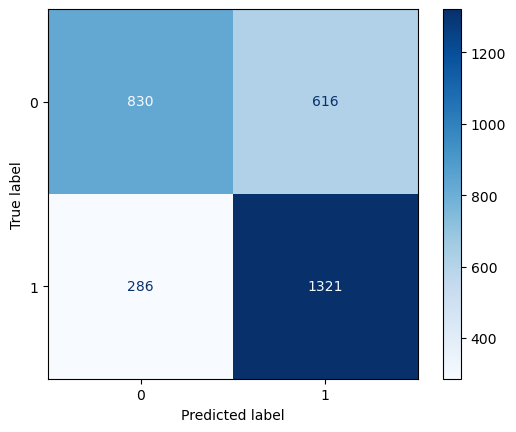

In [51]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_, 
                             )
disp.plot(cmap = "Blues", values_format='');

Type I errors are more common.  The model has a higher chance of predicting a false positive than false negative (over twice as likely). Instead, it would be more desirable for type II errors to be more common, since it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one, rather than to be disappointed by a low tip when they were expecting a generous one. Despite this bias, the overall performance of the model remains satisfactory.

##### Feature importance

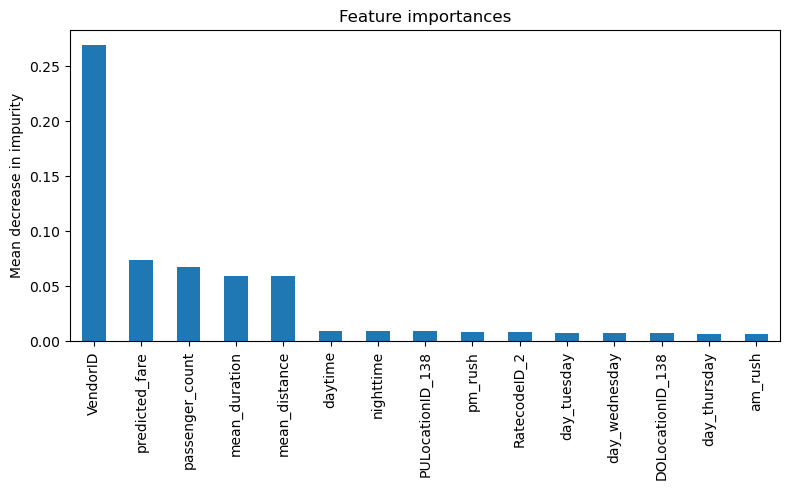

In [52]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

### **Conclusion**
This model shows promising results. Against the test set, it achieved an F<sub>1</sub> score of 0.7454, indicating an acceptable balance of precision and recall. Additionally, it demonstrated an overall accuracy of 0.704 (70%), correctly identifying 20% better than random guessing. This suggests the model has learned meaningful patterns from the data.

##### Explanability and Performance
While Random Forest excels in prediction accuracy, it can be challenging to understand exactly how it arrives at its conclusions.  Although we've identified key factors like `VendorID`, `predicted_fare`, `passenger_count`, `mean_duration`, and `mean_distance`, the specific way these features influence the model's tipping prediction requires further investigation.

While Random Forest was faster to train than XGBoost, taking only a third of the time (13 minutes as compared to 38 minutes), it's important to consider both speed and interpretability when choosing a machine learning model.  

Interestingly, `VendorID` emerged as the most significant feature in predicting generous tippers. This could suggest that one of two vendors attract riders who tip more frequently. To investigate this further, it might be valuable to conduct statistical tests to compare tipping behavior across different vendors.

##### Potential Next Steps
While this initial model didn't pinpoint definitively impactful features, it provides a valuable foundation for future iterations. By incorporating additional engineered features, we can potentially enhance the model's performance in identifying tipping trends. 

To further refine the model, it could also be beneficial to gather real-world feedback. Testing it with a select group of taxi drivers would provide valuable insights into its effectiveness in practical scenarios.